In [1]:
# To ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Import the libraries to handle the np array and pandas dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import py files
import acquire, prepare, explore

import psutil
from tqdm.notebook import tqdm
import gc

### Acquire and Prepare the Train/Validate/Test Dataset

In [2]:
%%time

# Define the data types
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16", 
    "content_type_id": "boolean", 
    "task_container_id": "int16",
    "user_answer": "int8", 
    "answered_correctly": "int8", 
    "prior_question_elapsed_time": "float32"   
}

# Load train/validate/test
df_train = pd.read_csv("../Riiid-Project/sampled_trainset.csv", index_col=0, dtype=dtypes)
df_validate = pd.read_csv("../Riiid-Project/validate.csv", index_col=0, dtype=dtypes)
df_test = pd.read_csv("../Riiid-Project/test.csv", index_col=0, dtype=dtypes)

CPU times: user 45 s, sys: 4.12 s, total: 49.1 s
Wall time: 49.8 s


In [3]:
%%time

# Define the data types
dtypes = {
    "question_id": "int16", 
    "bundle_id": "int16",
    "correct_answer": "int8", 
    "part": "int8", 
    "tags": "object", 
    "tag_count": "int8"    
    }

# Load questions dataset
df_ques = pd.read_csv('questions_with_tag_counts.csv', index_col=0, dtype=dtypes)

CPU times: user 8.17 ms, sys: 5.25 ms, total: 13.4 ms
Wall time: 13.4 ms


In [4]:
# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20964878 entries, 0 to 13083813322
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   content_type_id                 boolean
 3   task_container_id               int16  
 4   user_answer                     int8   
 5   answered_correctly              int8   
 6   prior_question_elapsed_time     float32
 7   prior_question_had_explanation  object 
 8   lecture_id                      float64
 9   tag                             float64
 10  lecture_part                    float64
 11  type_of                         object 
 12  question_id                     float64
 13  bundle_id                       float64
 14  correct_answer                  float64
 15  question_part                   float64
 16  tags                            object 
dtypes: boolean(1), float32

In [5]:
%%time

# Drop columns that are not needed

cols = ['lecture_id', 'tag', 'lecture_part','type_of', 'question_id', 'bundle_id', 
        'correct_answer', 'question_part', 'tags', 'content_type_id', 'user_answer']

df_train.drop(columns=cols, inplace=True)
df_validate.drop(columns=cols, inplace=True)
df_test.drop(columns=cols, inplace=True)

CPU times: user 492 ms, sys: 449 ms, total: 941 ms
Wall time: 1.03 s


In [6]:
# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20964878 entries, 0 to 13083813322
Data columns (total 6 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  object 
dtypes: float32(1), int16(2), int32(1), int8(1), object(1)
memory usage: 579.8+ MB


In [7]:
# Print the information of df_ques
df_ques.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13523 entries, 0 to 13522
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
 5   tag_count       13523 non-null  int8  
dtypes: int16(2), int8(3), object(1)
memory usage: 303.7+ KB


In [8]:
%%time
# Drop lecture rows

mask = (df_train.answered_correctly != -1)
df_train = df_train[mask]

mask = (df_validate.answered_correctly != -1)
df_validate = df_validate[mask]

mask = (df_test.answered_correctly != -1)
df_test = df_test[mask]

CPU times: user 1.05 s, sys: 480 ms, total: 1.53 s
Wall time: 1.74 s


In [9]:
%%time

# Merge df_train and df_ques
df_train = df_train.merge(df_ques, how='left', left_on='content_id', right_on='question_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  object 
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
dtypes: float32(1), int16(4), int32(1), int8(4), object(2)
memory usage: 862.5+ MB
CPU times: user 3.05 s, sys: 982 ms, total: 4.04 s
Wall time: 4.05 s


In [12]:
# Check the nulls in df_train
df_train.isnull().sum(axis=0)

user_id                               0
content_id                            0
task_container_id                     0
answered_correctly                    0
prior_question_elapsed_time       99720
prior_question_had_explanation    99720
question_id                           0
bundle_id                             0
correct_answer                        0
part                                  0
tags                                  1
tag_count                             0
dtype: int64

In [61]:
%%time

# Merge df_train and df_ques
df_validate = df_validate.merge(df_ques, how='left', left_on='content_id', right_on='question_id')
df_test = df_test.merge(df_ques, how='left', left_on='content_id', right_on='question_id')

CPU times: user 759 ms, sys: 280 ms, total: 1.04 s
Wall time: 1.08 s


In [13]:
# Check the nulls in df_validate
df_validate.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [14]:
# Check the nulls in df_test
df_test.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [15]:
%%time

# Fill the missing value in col `prior_question_elapsed_time` with 0
df_train.prior_question_elapsed_time.fillna(0, inplace=True)

# Fill the missing value in col `prior_question_had_explanation` with False
df_train.prior_question_had_explanation.fillna(False, inplace=True)

# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
dtypes: bool(1), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 725.3+ MB
CPU times: user 1.28 s, sys: 20.4 ms, total: 1.3 s
Wall time: 1.31 s


In [17]:
# Check the nulls in df_train
df_train.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
question_id                       0
bundle_id                         0
correct_answer                    0
part                              0
tags                              1
tag_count                         0
dtype: int64

### Add new features - user_ques_accuracy

In [19]:
%%time
# Compute the user_ques_accuracy

user_ques_accuracy = explore.compute_user_ques_acc(df_train)
user_ques_accuracy.head(2)

CPU times: user 7.04 s, sys: 2.69 s, total: 9.73 s
Wall time: 10 s


,user_id,content_id,user_ques_acc
0,24600,175,1.0
1,24600,1278,1.0


In [20]:
%%time
# Concat the user_ques_acc to the df_train

df_train = df_train.merge(user_ques_accuracy, how='left', 
                          left_on = ['user_id', 'content_id'], 
                          right_on = ['user_id', 'content_id'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_ques_acc                   float16
dtypes: bool(1), float16(1), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 764.5+ MB
CPU times: user 8.91 s, sys: 3.09 s, total: 12 s
Wall time: 12.1 s


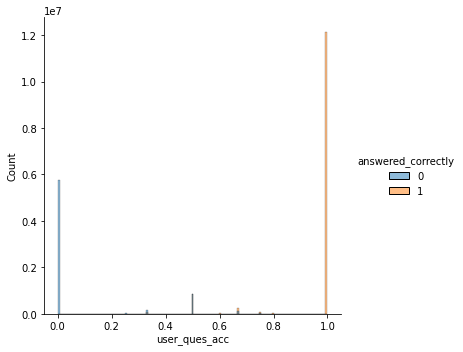

CPU times: user 5.61 s, sys: 1.28 s, total: 6.88 s
Wall time: 6.9 s


In [54]:
%%time
# Plot the distribution of values in column user_ques_acc

sns.displot(data=df_train, x='user_ques_acc', hue='answered_correctly')
plt.show()

In [24]:
%%time
# Concat the user_ques_acc to the df_validate

df_validate = df_validate.merge(user_ques_accuracy, how='left', 
                                left_on = ['user_id', 'content_id'], 
                                right_on = ['user_id', 'content_id'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 4.89 s, sys: 1.57 s, total: 6.46 s
Wall time: 6.5 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
dtype: int64

In [36]:
# What percent of the values in column user_ques-acc are missing? 
print(f"{round((2193284*100/df_validate.shape[0]),2)}% of the values in column user_ques_acc is missing")

86.32% of the values in column user_ques_acc is missing


In [38]:
%%time
# Concat the user_ques_acc to the df_test

df_test = df_test.merge(user_ques_accuracy, how='left', 
                        left_on = ['user_id', 'content_id'], 
                        right_on = ['user_id', 'content_id'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 4.89 s, sys: 1.66 s, total: 6.55 s
Wall time: 6.59 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
dtype: int64

In [66]:
# What percent of the values in the column user_ques_acc are missing?
print(f"{round((2312506*100/df_test.shape[0]),2)}% of the values in column user_ques_acc is missing")

87.44% of the values in column user_ques_acc is missing


**Takeaways**: About 87% of the questions in the validate and test dataset are new to the users. 

### Add new features - user_bundle_accuracy

In [56]:
%%time
# Compute the user_bundle_accuracy

user_bundle_accuracy = explore.compute_user_bundle_acc(df_train)
user_bundle_accuracy.head(2)

CPU times: user 5.76 s, sys: 2.13 s, total: 7.89 s
Wall time: 8.06 s


,user_id,bundle_id,user_bundle_acc
0,24600,175,1.0
1,24600,1278,1.0


In [58]:
%%time
# Concat the user_bundle_acc to the df_train

df_train = df_train.merge(user_bundle_accuracy, how='left', 
                          left_on = ['user_id', 'bundle_id'], 
                          right_on = ['user_id', 'bundle_id'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 14 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_ques_acc                   float16
 13  user_bundle_acc                 float16
dtypes: bool(1), float16(2), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 803.7+ MB
CPU times: user 7.61 s, sys: 2.79 s, total: 10.4 s
Wall time:

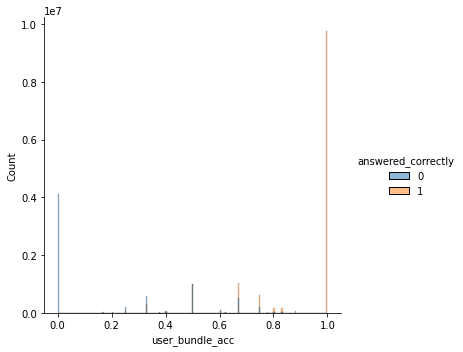

CPU times: user 5.79 s, sys: 1.1 s, total: 6.89 s
Wall time: 6.81 s


In [76]:
%%time
# Plot the distribution of values in column user_bundle_acc

sns.displot(data=df_train, x='user_bundle_acc', hue='answered_correctly')
plt.show()

In [65]:
%%time
# Concat the user_bundle_acc to the df_validate

df_validate = df_validate.merge(user_bundle_accuracy, how='left', 
                                left_on = ['user_id', 'bundle_id'], 
                                right_on = ['user_id', 'bundle_id'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 4.05 s, sys: 1.52 s, total: 5.57 s
Wall time: 5.74 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2147909
dtype: int64

In [67]:
# What percent of the values in column user_bundle_acc are missing? 
print(f"{round((2147909*100/df_validate.shape[0]),2)}% of the values in column user_bundle_acc is missing")

84.53% of the values in column user_bundle_acc is missing


In [69]:
%%time
# Concat the user_bundle_acc to the df_test

df_test = df_test.merge(user_bundle_accuracy, how='left', 
                        left_on = ['user_id', 'bundle_id'], 
                        right_on = ['user_id', 'bundle_id'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 4.17 s, sys: 1.24 s, total: 5.41 s
Wall time: 5.46 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2312095
dtype: int64

In [70]:
# What percent of the values in column user_bundle_acc are missing? 
print(f"{round((2312095*100/df_test.shape[0]),2)}% of the values in column user_bundle_acc is missing")

87.43% of the values in column user_bundle_acc is missing


**Takeaways**: About 86% of the bundles in the validate and test dataset are new to the users. 

### Add new features - user_tags_accuracy

In [72]:
%%time
# Compute the user_tags_accuracy

user_tags_accuracy = explore.compute_user_tags_acc(df_train)
user_tags_accuracy.head(2)

CPU times: user 4.46 s, sys: 1.34 s, total: 5.8 s
Wall time: 5.9 s


,user_id,tags,user_tags_acc
0,24600,1,0.0
1,24600,10 94 92,0.0


In [78]:
%%time
# Concat the user_part_acc to the df_train

df_train = df_train.merge(user_tags_accuracy, how='left', 
                          left_on = ['user_id', 'tags'], 
                          right_on = ['user_id', 'tags'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 15 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_ques_acc                   float16
 13  user_bundle_acc                 float16
 14  user_tags_acc                   float16
dtypes: bool(1), float16(3), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 842.9+ MB
CPU times: user 

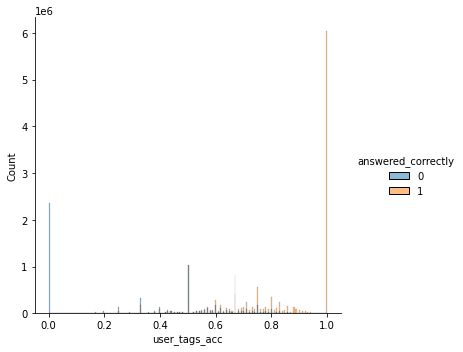

CPU times: user 6.68 s, sys: 1.46 s, total: 8.14 s
Wall time: 8.19 s


In [79]:
%%time
# Plot the distribution of values in column user_tags_acc

sns.displot(data=df_train, x='user_tags_acc', hue='answered_correctly')
plt.show()

In [82]:
%%time
# Concat the user_tags_acc to the df_validate

df_validate = df_validate.merge(user_tags_accuracy, how='left', 
                                left_on = ['user_id', 'tags'], 
                                right_on = ['user_id', 'tags'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 2.56 s, sys: 737 ms, total: 3.3 s
Wall time: 3.33 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2147909
user_tags_acc                      757773
dtype: int64

In [83]:
# What percent of the values in column user_tags_acc are missing? 
print(f"{round((757773*100/df_validate.shape[0]),2)}% of the values in column user_tags_acc is missing")

29.82% of the values in column user_tags_acc is missing


In [84]:
%%time
# Concat the user_tags_acc to the df_test

df_test = df_test.merge(user_tags_accuracy, how='left', 
                        left_on = ['user_id', 'tags'], 
                        right_on = ['user_id', 'tags'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 2.6 s, sys: 775 ms, total: 3.38 s
Wall time: 3.41 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2312095
user_tags_acc                      831523
dtype: int64

In [85]:
# What percent of the values in column user_tags_acc are missing? 
print(f"{round((831523*100/df_test.shape[0]),2)}% of the values in column user_tags_acc is missing")

31.44% of the values in column user_tags_acc is missing


**Takeaways**: About 30% of the tags in the validate and test dataset are new to the users. 

### Add new features - user_part_accuracy

In [88]:
%%time
# Compute the user_part_accuracy

user_part_accuracy = explore.compute_user_part_acc(df_train)
user_part_accuracy.head(2)

CPU times: user 1.07 s, sys: 613 ms, total: 1.69 s
Wall time: 1.71 s


,user_id,part,user_part_acc
0,24600,1,0.669922
1,24600,2,1.000000


In [89]:
%%time
# Concat the user_part_acc to the df_train

df_train = df_train.merge(user_part_accuracy, how='left', 
                          left_on = ['user_id', 'part'], 
                          right_on = ['user_id', 'part'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 16 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_ques_acc                   float16
 13  user_bundle_acc                 float16
 14  user_tags_acc                   float16
 15  user_part_acc                   float16
dtypes: bool(1), float16(4), float32(1), int16(4), int32(1), int8(4), objec

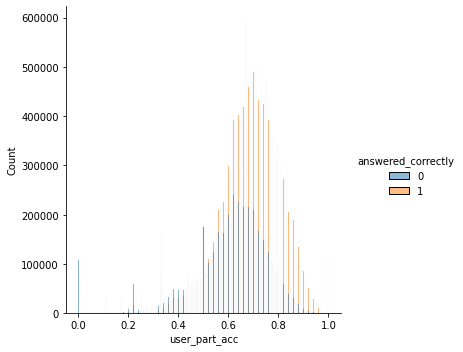

CPU times: user 7.87 s, sys: 1.13 s, total: 9 s
Wall time: 8.9 s


In [93]:
%%time
# Plot the distribution of values in column user_part_acc

sns.displot(data=df_train, x='user_part_acc', hue='answered_correctly')
plt.show()

In [94]:
%%time
# Concat the user_part_acc to the df_validate

df_validate = df_validate.merge(user_part_accuracy, how='left', 
                                left_on = ['user_id', 'part'], 
                                right_on = ['user_id', 'part'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 559 ms, sys: 186 ms, total: 745 ms
Wall time: 744 ms


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2147909
user_tags_acc                      757773
user_part_acc                       41473
dtype: int64

In [95]:
# What percent of the values in column user_part_acc are missing? 
print(f"{round((41473*100/df_validate.shape[0]),2)}% of the values in column user_part_acc is missing")

1.63% of the values in column user_part_acc is missing


In [96]:
%%time
# Concat the user_part_acc to the df_test

df_test = df_test.merge(user_part_accuracy, how='left', 
                        left_on = ['user_id', 'part'], 
                        right_on = ['user_id', 'part'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 590 ms, sys: 182 ms, total: 772 ms
Wall time: 771 ms


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2312095
user_tags_acc                      831523
user_part_acc                       90722
dtype: int64

In [98]:
# What percent of the values in column user_part_acc are missing? 
print(f"{round((90722*100/df_test.shape[0]),2)}% of the values in column user_part_acc is missing")

3.43% of the values in column user_part_acc is missing


**Takeaways**: 2% of the users in the validate and test dataset are going to answer the questions in the new parts. 

### Add new feature - user_tagcount_accuracy

In [100]:
%%time
# Compute the user_tagcount_accuracy

user_tagcount_accuracy = explore.compute_user_tagcount_acc(df_train)
user_tagcount_accuracy.head(2)

CPU times: user 1.07 s, sys: 647 ms, total: 1.72 s
Wall time: 1.75 s


,user_id,tag_count,user_tagcount_acc
0,24600,1,0.300049
1,24600,3,0.170044


In [101]:
%%time
# Concat the user_tagcount_acc to the df_train

df_train = df_train.merge(user_tagcount_accuracy, how='left', 
                          left_on = ['user_id', 'tag_count'], 
                          right_on = ['user_id', 'tag_count'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_ques_acc                   float16
 13  user_bundle_acc                 float16
 14  user_tags_acc                   float16
 15  user_part_acc                   float16
 16  user_tagcount_acc               float16
dtypes: bool(1), float16(5), f

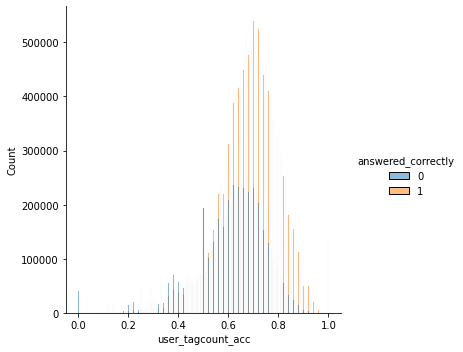

CPU times: user 8.27 s, sys: 1.11 s, total: 9.38 s
Wall time: 9.29 s


In [102]:
%%time
# Plot the distribution of values in column user_part_acc

sns.displot(data=df_train, x='user_tagcount_acc', hue='answered_correctly')
plt.show()

In [104]:
%%time
# Concat the user_tagcount_acc to the df_validate

df_validate = df_validate.merge(user_tagcount_accuracy, how='left', 
                                left_on = ['user_id', 'tag_count'], 
                                right_on = ['user_id', 'tag_count'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 577 ms, sys: 192 ms, total: 769 ms
Wall time: 769 ms


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2147909
user_tags_acc                      757773
user_part_acc                       41473
user_tagcount_acc                   14165
dtype: int64

In [105]:
# What percent of the values in column user_tagcount_acc are missing? 
print(f"{round((14165*100/df_validate.shape[0]),2)}% of the values in column user_tagcount_acc is missing")

0.56% of the values in column user_tagcount_acc is missing


In [106]:
%%time
# Concat the user_tagcount_acc to the df_test

df_test = df_test.merge(user_tagcount_accuracy, how='left', 
                        left_on = ['user_id', 'tag_count'], 
                        right_on = ['user_id', 'tag_count'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 608 ms, sys: 209 ms, total: 817 ms
Wall time: 819 ms


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2312095
user_tags_acc                      831523
user_part_acc                       90722
user_tagcount_acc                   23591
dtype: int64

In [107]:
# What percent of the values in column user_tagcount_acc are missing? 
print(f"{round((23591*100/df_test.shape[0]),2)}% of the values in column user_tagcount_acc is missing")

0.89% of the values in column user_tagcount_acc is missing


**Takeaways:** Less than 1% of the users in the validate and test dataset are going to answer the questions in the a new tagcount.

### Create new feature - question accuracy

In [109]:
%%time
# Compute the ques_accuracy

ques_accuracy = explore.compute_ques_acc(df_train)
ques_accuracy.head(2)

CPU times: user 590 ms, sys: 282 ms, total: 872 ms
Wall time: 990 ms


,ques_acc
content_id,
0,0.910156
1,0.899902


In [110]:
%%time
# Concat ques_accuracy to the df_train

df_train = df_train.merge(ques_accuracy, how='left', on='content_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 18 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_ques_acc                   float16
 13  user_bundle_acc                 float16
 14  user_tags_acc                   float16
 15  user_part_acc                   float16
 16  user_tagcount_acc               float16
 17  ques_acc                 

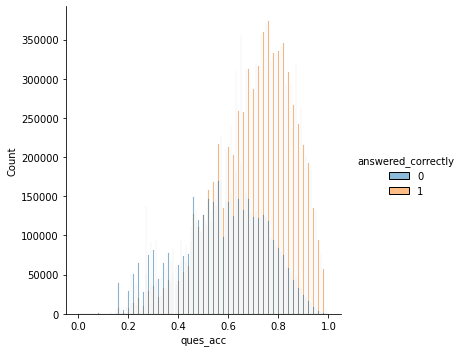

CPU times: user 7.71 s, sys: 1.47 s, total: 9.18 s
Wall time: 9.27 s


In [111]:
%%time
# Plot the distribution of values in column user_part_acc

sns.displot(data=df_train, x='ques_acc', hue='answered_correctly', )
plt.show()

In [112]:
%%time
# Concat ques_accuracy to the df_validate

df_validate = df_validate.merge(ques_accuracy, how='left', on='content_id')

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 580 ms, sys: 197 ms, total: 777 ms
Wall time: 776 ms


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2147909
user_tags_acc                      757773
user_part_acc                       41473
user_tagcount_acc                   14165
ques_acc                                3
dtype: int64

In [113]:
# What percent of the values in column ques_acc are missing? 
print(f"{round((3*100/df_validate.shape[0]),2)}% of the values in column ques_acc is missing")

0.0% of the values in column ques_acc is missing


In [114]:
%%time
# Concat ques_accuracy to the df_test

df_test = df_test.merge(ques_accuracy, how='left', on='content_id')

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 616 ms, sys: 218 ms, total: 835 ms
Wall time: 834 ms


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2312095
user_tags_acc                      831523
user_part_acc                       90722
user_tagcount_acc                   23591
ques_acc                                1
dtype: int64

In [115]:
# What percent of the values in column ques_acc are missing? 
print(f"{round((1*100/df_test.shape[0]),2)}% of the values in column ques_acc is missing")

0.0% of the values in column ques_acc is missing


**Takeaways:** Less than 0.1% of the questions in the validate and test dataset are new.

### Drop the columns that are not used in modeling

In [126]:
%%time
# Drop the columns

cols = ['user_id', 'content_id', 'task_container_id', 'question_id',
        'bundle_id', 'correct_answer', 'part', 'tags', 'tag_count',]

train = df_train.drop(columns=cols)
validate = df_validate.drop(columns=cols)
test = df_test.drop(columns=cols)

CPU times: user 773 ms, sys: 1.09 s, total: 1.86 s
Wall time: 1.98 s


In [133]:
# Check the missing values in the validate
train.isnull().sum(axis=0)

answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_ques_acc                     0
user_bundle_acc                   0
user_tags_acc                     1
user_part_acc                     0
user_tagcount_acc                 0
ques_acc                          0
dtype: int64

In [131]:
# Check the missing values in the validate
validate.isnull().sum(axis=0)

answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
user_bundle_acc                   2147909
user_tags_acc                      757773
user_part_acc                       41473
user_tagcount_acc                   14165
ques_acc                                3
dtype: int64

In [132]:
# Check the missing values in the validate
test.isnull().sum(axis=0)

answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
user_bundle_acc                   2312095
user_tags_acc                      831523
user_part_acc                       90722
user_tagcount_acc                   23591
ques_acc                                1
dtype: int64

### Fill the missing values with 0

In [134]:
train.fillna(0, inplace=True)
validate.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [136]:
# Check the missing values in the validate
train.isnull().sum(axis=0)

answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_ques_acc                     0
user_bundle_acc                   0
user_tags_acc                     0
user_part_acc                     0
user_tagcount_acc                 0
ques_acc                          0
dtype: int64

In [137]:
# Check the missing values in the validate
validate.isnull().sum(axis=0)

answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_ques_acc                     0
user_bundle_acc                   0
user_tags_acc                     0
user_part_acc                     0
user_tagcount_acc                 0
ques_acc                          0
dtype: int64

In [138]:
# Check the missing values in the validate
test.isnull().sum(axis=0)

answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_ques_acc                     0
user_bundle_acc                   0
user_tags_acc                     0
user_part_acc                     0
user_tagcount_acc                 0
ques_acc                          0
dtype: int64

### Convert boolean to numeric

In [142]:
%%time
# Convert the boolean values to 1 and 0

train.prior_question_had_explanation = train.prior_question_had_explanation.map({True: 1, False: 0})
validate.prior_question_had_explanation = validate.prior_question_had_explanation.map({True: 1, False: 0})
test.prior_question_had_explanation = test.prior_question_had_explanation.map({True: 1, False: 0})

CPU times: user 1.23 s, sys: 218 ms, total: 1.45 s
Wall time: 1.46 s


In [148]:
# Print 5 random sample of the train dataset
train.sample(5)

,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_ques_acc,user_bundle_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc
15766013,1,23000.0,1,1.0,0.669922,1.000000,0.589844,0.629883,0.449951
16161878,1,39000.0,1,1.0,0.500000,0.669922,0.620117,0.609863,0.649902
5620173,0,43680.0,1,0.0,0.669922,0.529785,0.529785,0.580078,0.779785
11699250,1,55000.0,1,1.0,1.000000,0.799805,0.689941,0.700195,0.680176
6606026,0,22000.0,0,0.0,0.330078,0.000000,0.330078,0.170044,0.160034


In [145]:
%%time
# Cast the int64 to int8

train.prior_question_had_explanation = train.prior_question_had_explanation.astype('int8')
validate.prior_question_had_explanation = validate.prior_question_had_explanation.astype('int8')
test.prior_question_had_explanation = test.prior_question_had_explanation.astype('int8')

CPU times: user 41.1 ms, sys: 23.8 ms, total: 64.9 ms
Wall time: 62.5 ms


In [147]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   answered_correctly              int8   
 1   prior_question_elapsed_time     float32
 2   prior_question_had_explanation  int8   
 3   user_ques_acc                   float16
 4   user_bundle_acc                 float16
 5   user_tags_acc                   float16
 6   user_part_acc                   float16
 7   user_tagcount_acc               float16
 8   ques_acc                        float16
dtypes: float16(6), float32(1), int8(2)
memory usage: 509.7 MB


In [146]:
# Release memory
print("Memory usage before running garbage collector: ", psutil.virtual_memory().percent)
gc.collect
print("Memory usage after: ", psutil.virtual_memory().percent)

Memory usage before running garbage collector:  73.4
Memory usage after:  73.4


### Scale the continues variables

In [141]:
train.head(2)

,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_ques_acc,user_bundle_acc,user_tags_acc,user_part_acc,user_tagcount_acc,ques_acc
0,1,0.0,False,1.0,1.0,1.0,0.669922,0.170044,0.819824
1,0,24000.0,False,0.0,0.0,0.0,0.669922,0.170044,0.409912
